In [10]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader
from importlib import reload
import winsound
import dill, wandb, json,os
import datetime as dt
if wandblog:
    !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf

Notebook
GPU detected


In [20]:
with open('compare/experiments/base.json') as file:
    construct_dict = json.load(file)

construct_dict['hyper_params']['hidden_states']=int(32)
construct_dict['data_params']['n_data']=int(2e4)   #just for tests, otherwise comment out  
construct_dict['data_params']['db_path']=construct_dict['data_params']['db_path'][3:]
construct_dict['data_params']['transform_path']=construct_dict['data_params']['transform_path'][3:]
construct_dict['group']='grad_tracker'

In [17]:
######
#dependencies
######

cwd=os.getcwd()
def get_lr_schedule(construct_dict):
    schedule  = construct_dict['run_params']['lr_schedule']
    lr_0        = construct_dict['run_params']['learning_rate']
    warm_up        = construct_dict['run_params']['warm_up']
    decay       = construct_dict['run_params']['lr_decay']

    import from_config.dev.lr_schedules as lr_module

    lr_generator = getattr(lr_module, schedule)

    lr_schedule  = lr_generator(lr_0, warm_up, decay)()

    return lr_schedule



def get_metrics(metric_name):
    # Returns a list of functions
    import from_config.dev.metrics as metrics
    metrics=getattr(metrics, metric_name)
    return metrics


def get_loss_func(name):
    # Return loss func from the loss functions file given a function name
    import from_config.dev.loss_funcs as loss_func_module
    loss_func = getattr(loss_func_module, name)
    return loss_func


def get_performance(name):
    # Return performance plotter from the eval_model file given a name
    import from_config.dev.eval_model as evals
    performance_plot = getattr(evals, name)
    return performance_plot 

def setup_model(construct_dict):
    # Retrieve name and params for construction
    model_name    = construct_dict['model_name']
    hyper_params  = construct_dict['hyper_params']
    experiment    = construct_dict['experiment']

    # Load model from model folder
    import from_config.dev.models as models
    model         = getattr(models, model_name) 
    model         = model(**hyper_params)

    # Make folder for saved states
    model_path    = osp.join(cwd, "trained_models", experiment)
    if not osp.isdir(model_path):
        os.makedirs(model_path)

    return model, model_path

In [65]:
def train_model(construct_dict):
    """
    Train a model given a construction dictionairy
    """

    # Setup Log 
    wandblog=construct_dict["wandblog"]
#     wandblog=0
    if wandblog:
        import wandb
        run = wandb.init(project = construct_dict["experiment"], entity = "chri862z", group=construct_dict["group"], config = construct_dict, reinit=True)
#         wandb.run.name = construct_dict['model_name']+'_'+construct_dict['experiment_name']+'_'+str(wandb.run.id)
        wandb.run.name = construct_dict['model_name']+'_'+str(wandb.run.id)
    ################################################
    #   Load dataset                              #
    ################################################
    from from_config.dev.data_load import graph_data
    #load dataset
    epochs      = construct_dict['run_params']['epochs']
    epochs=20
    batch_size  = construct_dict['run_params']['batch_size']
    
    dataset=graph_data(**construct_dict['data_params'])
    
    idx_lists = dataset.index_lists
    # Split data
    dataset_train = dataset[idx_lists[0]]
    dataset_val   = dataset[idx_lists[1]]
    dataset_test  = dataset[idx_lists[2]]

    loader_train = DisjointLoader(dataset_train, epochs=epochs, batch_size=batch_size)
    loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
    loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)

     ###############################################
    #   Setup other run params                     #
    ################################################

    early_stop  = construct_dict['run_params']['early_stop']
    patience    = construct_dict['run_params']['patience']
    val_epoch = construct_dict['run_params']['val_epoch']

    print('check')
    ################################################
    #   Setup model, loss, lr schedule and metrics #
    ################################################

    # Get model, metrics, lr_schedule and loss function
    model, model_path     = setup_model(construct_dict)
    loss_func             = get_loss_func(construct_dict['run_params']['loss_func'])
    metrics               = get_metrics(construct_dict['run_params']['metrics'])
    performance_plot      = get_performance(construct_dict['run_params']['performance_plot'])
    lr_schedule          = get_lr_schedule(construct_dict)
    save_path=osp.join(model_path,wandb.run.name)

    if not osp.isdir(save_path):
        os.makedirs(save_path)
        print('New folder for saving run made')

    # Learning rate and optimizer
    learning_rate            = next(lr_schedule)
    opt           = Adam(learning_rate)

    ################################################
    #   Set up TF functions and validation step   #
    ################################################


    # Define training function
    @tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = model(inputs, training = True)
            targets     = tf.cast(targets, tf.float32)
            loss        = loss_func(predictions, targets)
            loss       += sum(model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    @tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
    def test_step(inputs, targets):
        predictions = model(inputs, training = False)
        targets     = tf.cast(targets, tf.float32) 
        out         = loss_func(predictions, targets)

        return predictions, targets, out


    def validation(loader):
        loss = 0
        prediction_list, target_list = [], []
        for batch in loader:
            inputs, targets = batch
            predictions, targets, out = test_step(inputs, targets)
            loss           += out
            
            prediction_list.append(predictions)
            target_list.append(targets)
        
        y_reco  = tf.concat(prediction_list, axis = 0)
        y_true  = tf.concat(target_list, axis = 0)
        y_true  = tf.cast(y_true, tf.float32)

        loss, loss_from = loss_func(y_reco, y_true, re=True)
        
        energy, e_old, alpha, zeni, azi= metrics(y_reco, y_true)
        
        return loss, loss_from, [energy, e_old, alpha, zeni, azi]

    # Define grad tracking function
    @tf.function(input_signature = loader_val.tf_signature(), experimental_relax_shapes = True)
    def gradient_importance(inputs, targets):
        with tf.GradientTape() as tape:
            tape.watch(inputs[0])
            predictions = model(inputs, training=False)
        grads = tape.gradient(predictions, inputs[0])
        grads=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
        tf.print(tf.math.reduce_max(inputs[2]))
        grads=tf.math.segment_mean(tf.math.abs(grads), inputs[2], name=None)
        return grads

    ################################################
    #  Train Model                                 #      
    ################################################

    tot_time=0
    current_batch = 0
    current_epoch = 1
    loss          = 0
    lowest_loss   = np.inf
    early_stop    = 1
    early_stop_counter    = 0
    pbar          = tqdm(total = loader_train.steps_per_epoch, position=0, leave = True)
    start_time    = time.time()
    summarylist=[]
    grad_list=[]
    grad_mean=[]
    for batch in loader_train:
        inputs, targets = batch
        out             = train_step(inputs, targets)
        loss           += out
        if current_epoch==1 and current_batch==0:
            model.summary()
            if wandblog:
                summary=model.summary(print_fn=summarylist.append)
                table=wandb.Table(columns=["Layers"])
                for s in summarylist:
                    table.add_data(s)
                wandb.log({'Model summary': table})
        current_batch  += 1
        pbar.update(1)
        pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")
        
        if current_batch == loader_train.steps_per_epoch:
            t=time.time() - start_time
            tot_time+=t
            print(f"Epoch {current_epoch} of {epochs} done in {t:.2f} seconds using learning rate: {learning_rate:.2E}")
            print(f"Avg loss of train: {loss / loader_train.steps_per_epoch:.6f}")

            loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)
            val_loss, val_loss_from, val_metric = validation(loader_val)
            if wandblog:
                wandb.log({"Train Loss":      loss / loader_train.steps_per_epoch,
                        "Validation Loss": val_loss, 
                        "w(log(E))":   val_metric[1],
                        "Energy bias":   val_metric[0][1],
                        "Energy sig-1":   val_metric[0][0],
                        "Energy sig+1":   val_metric[0][2],
                        "Solid angle 68th":    val_metric[2][3],
                        "Angle bias":   val_metric[2][1],
                        "Angle sig-1":   val_metric[2][0],
                        "Angle sig+1":   val_metric[2][2],
                        "zenith 68th":    val_metric[3][3],
                        "zenith bias":   val_metric[3][1],
                        "zenith sig-1":   val_metric[3][0],
                        "zenith sig+1":   val_metric[3][2],
                        "azimuth 68th":    val_metric[4][3],
                        "azimuth bias":   val_metric[4][1],
                        "azimuth sig-1":   val_metric[4][0],
                        "azimuth sig+1":   val_metric[4][2],
                        "Learning rate":   learning_rate})
            grads=gradient_importance(inputs, targets)
            grads_av=tf.reduce_mean(grads, axis=1)
            grads_av1=tf.reduce_mean(grads, axis=0)
            tf.print(grads_av)
            tf.print(grads_av1)
            grad_list.append(grads)
            grad_mean.append(grads_av)
            if not construct_dict['run_params']['zeniazi_metric']:
                print(f"Avg loss of validation: {val_loss:.6f}")
                print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
                print(f"Energy: bias = {val_metric[0][1]:.6f} sig_range = {val_metric[0][0]:.6f}<->{val_metric[0][2]:.6f}, old metric {val_metric[1]:.6f}\
                    \n Angle: bias = {val_metric[2][1]:.6f} sig_range = {val_metric[2][0]:.6f}<->{val_metric[2][2]:.6f}, old metric {val_metric[2][3]:.6f}")
            else:
                print(f"Avg loss of validation: {val_loss:.6f}")
                print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
                print(f"Energy: bias = {val_metric[0][1]:.6f} sig_range = {val_metric[0][0]:.6f}<->{val_metric[0][2]:.6f}, old metric {val_metric[1]:.6f}\
                    \n Angle: bias = {val_metric[2][1]:.6f} sig_range = {val_metric[2][0]:.6f}<->{val_metric[2][2]:.6f}, old metric {val_metric[2][3]:.6f}\
                    \n Zenith: bias = {val_metric[3][1]:.6f} sig_range = {val_metric[3][0]:.6f}<->{val_metric[3][2]:.6f}, old metric {val_metric[3][3]:.6f}\
                    \n Azimuth: bias = {val_metric[4][1]:.6f} sig_range = {val_metric[4][0]:.6f}<->{val_metric[4][2]:.6f}, old metric {val_metric[4][3]:.6f}")

            if val_loss < lowest_loss:
                early_stop_counter = 0
                lowest_loss        = val_loss
            else:
                early_stop_counter += 1
            print(f'Early stop counter: {early_stop_counter}/{patience}, lowest val loss was {lowest_loss:.6f}')
            if early_stop and (early_stop_counter >= patience):
                model.save(save_path)
                print(f"Stopped training. No improvement was seen in {patience} epochs")
#                 return current_epoch

            if current_epoch != epochs:
                pbar          = tqdm(total = loader_train.steps_per_epoch, position=0, leave = True)

            learning_rate = next(lr_schedule)
            opt.learning_rate.assign(learning_rate)

            time_avg=tot_time/current_epoch
            if current_epoch % val_epoch == 0:
                model.save(save_path)
                print("Model saved")
                if wandblog:
                    loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
                    fig, _ = performance_plot(loader_test, test_step, metrics, save=True, save_path=save_path)
                    title="performanceplot_"+str(current_epoch)
                    wandb.log({title: [wandb.Image(fig, caption=title)]})
        
            loss            = 0
            start_time      = time.time()
            current_epoch  += 1
            current_batch   = 0
    return grad_list, grad_mean
    

_runtime,371
_timestamp,1618586598
_step,17
Train Loss,0.0296
Validation Loss,-0.26024
w(log(E)),0.19699
Energy bias,0.15692
Energy sig-1,0.04713
Energy sig+1,0.38191
Solid angle 68th,55.13118
Angle bias,40.64521


_runtime,▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
Train Loss,█▇▅▄▂▂▂▂▁▁▁▁▁▁▁▁
Validation Loss,█▆▃▄▂▂▁▁▁▂▁▁▁▁▁▁
w(log(E)),▆█▅█▂▂▂▁▂▂▁▁▁▁▁▁
Energy bias,█▆▂▃▁▁▁▁▁▁▁▁▁▁▁▁
Energy sig-1,█▅▁▂▁▁▁▁▁▁▁▁▁▁▁▁
Energy sig+1,█▇▃▅▁▁▁▁▁▁▁▁▁▁▁▁
Solid angle 68th,▇▇█▄▂▁▂▂▂▁▂▃▂▂▁▂
Angle bias,▇▇█▄▂▁▂▂▁▁▂▃▁▂▁▂


wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Loading data to memory
check
New folder for saving run made


Model: "sage_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
mp_21 (MP)                   multiple                  17056     
_________________________________________________________________
graph_sage_conv_42 (GraphSag multiple                  4096      
_________________________________________________________________
graph_sage_conv_43 (GraphSag multiple                  16384     
_________________________________________________________________
global_max_pool_21 (GlobalMa multiple                  0         
_________________________________________________________________
global_avg_pool_21 (GlobalAv multiple                  0         
_________________________________________________________________
global_sum_pool_21 (GlobalSu multiple                  0   

Epoch 2 of 20 done in 17.17 seconds using learning rate: 2.50E-04
Avg loss of train: 4.910212
127
[0.045586483075401342 0.0405993679170334 0.027819080065800413 ... 0.029411315386162391 0.029975260218342296 0.034278738013490746]
[0.088476854411110653 0.087354828960555 0.034573705560476717 0.016914821079531652 0.020936967874204335 0.020003885349507939]
Avg loss of validation: 4.757013
Loss from:  Energy: 2.951121 	 Angle: 1.090511 
Energy: bias = 2.610449 sig_range = 1.699715<->3.924119, old metric 1.081921                    
 Angle: bias = 139.814514 sig_range = 112.446823<->160.910767, old metric 151.161209                    
 Zenith: bias = 130.261841 sig_range = 96.812477<->155.516663, old metric 143.831924                    
 Azimuth: bias = 69.816772 sig_range = 21.090204<->137.142105, old metric 102.265640
Early stop counter: 0/5, lowest val loss was 4.757013


Epoch 3 of 20 done in 17.63 seconds using learning rate: 5.00E-04
Avg loss of train: 3.370092
127
[0.026160578137995005 0.039412821015574473 0.044596595195913254 ... 0.034036040446386695 0.03408041362627668 0.11098994390286626]
[0.088628258882060912 0.079771902226957875 0.033650319216298463 0.018569224328855934 0.01834615439934557 0.020265491727662906]
Avg loss of validation: 2.046036
Loss from:  Energy: 0.930150 	 Angle: 0.416815 
Energy: bias = 0.950446 sig_range = 0.380803<->1.403502, old metric 0.495328                    
 Angle: bias = 119.134224 sig_range = 57.231018<->154.924393, old metric 138.086456                    
 Zenith: bias = 105.901810 sig_range = 17.122101<->148.084534, old metric 127.001274                    
 Azimuth: bias = 72.162407 sig_range = 19.353832<->136.779160, old metric 105.905960
Early stop counter: 0/5, lowest val loss was 2.046036


Epoch 4 of 20 done in 16.46 seconds using learning rate: 1.00E-03
Avg loss of train: 2.121330
127
[0.043953891415578344 0.040444340019428378 0.031875697829214032 ... 0.032902683752719458 0.053717445104820509 0.082325453644559274]
[0.11377926057857331 0.10305812415180776 0.066735359579726442 0.02567958785874078 0.023106482522282149 0.025844477806311942]
Avg loss of validation: 1.024549
Loss from:  Energy: 0.568553 	 Angle: -0.284419 
Energy: bias = 0.341048 sig_range = 0.113759<->0.770947, old metric 0.324933                    
 Angle: bias = 46.569168 sig_range = 21.302631<->95.755493, old metric 64.231056                    
 Zenith: bias = 18.406237 sig_range = 5.213494<->52.299450, old metric 29.415047                    
 Azimuth: bias = 73.102966 sig_range = 20.170588<->137.042114, old metric 105.887306
Early stop counter: 0/5, lowest val loss was 1.024549


Epoch 5 of 20 done in 16.06 seconds using learning rate: 9.00E-04
Avg loss of train: 1.385279
127
[0.13260905551037586 0.09568800700254626 0.10294535536980831 ... 0.066325519908372238 0.11340930611512358 0.011801524826384387]
[0.16048445557544977 0.14776538063274336 0.13798421821472248 0.041492516176762931 0.030455307934072251 0.038190339649099278]
Avg loss of validation: 0.160619
Loss from:  Energy: 0.301472 	 Angle: -0.848462 
Energy: bias = 0.208624 sig_range = 0.060242<->0.474073, old metric 0.299980                    
 Angle: bias = 40.026169 sig_range = 18.357670<->72.111626, old metric 53.882004                    
 Zenith: bias = 11.792500 sig_range = 3.348528<->26.700884, old metric 18.217222                    
 Azimuth: bias = 72.750351 sig_range = 19.876957<->139.531647, old metric 110.111267
Early stop counter: 0/5, lowest val loss was 0.160619


Epoch 6 of 20 done in 18.19 seconds using learning rate: 8.10E-04
Avg loss of train: 0.924934
127
[0.25521671237745175 0.1726230253183311 0.16997985564570017 ... 0.1334197502460216 0.13641150663508339 0.23365840659056217]
[0.3012349960700153 0.25345604797318316 0.22680715249777691 0.077491041251593021 0.05093129719060658 0.073681047370512009]
Avg loss of validation: -0.031362
Loss from:  Energy: 0.204692 	 Angle: -0.941986 
Energy: bias = 0.156128 sig_range = 0.047564<->0.348050, old metric 0.231327                    
 Angle: bias = 39.347797 sig_range = 16.991674<->74.093910, old metric 54.307030                    
 Zenith: bias = 10.670550 sig_range = 3.081928<->23.651592, old metric 16.386457                    
 Azimuth: bias = 73.172668 sig_range = 19.830730<->138.477600, old metric 108.746513
Early stop counter: 0/5, lowest val loss was -0.031362


Epoch 7 of 20 done in 19.28 seconds using learning rate: 7.29E-04
Avg loss of train: 0.656626
127
[0.0364794801056648 0.34269198805956941 0.40478665878116121 ... 0.18465837609449712 0.36295011059686949 0.13491980439274606]
[0.41925315392242818 0.36742592303500032 0.35070328054355854 0.095765076243675029 0.059080405739229729 0.0973221886303751]
Avg loss of validation: -0.237047
Loss from:  Energy: 0.204837 	 Angle: -1.135697 
Energy: bias = 0.155703 sig_range = 0.040925<->0.364109, old metric 0.210006                    
 Angle: bias = 43.270443 sig_range = 18.797934<->80.159454, old metric 59.896236                    
 Zenith: bias = 8.668128 sig_range = 2.558384<->19.571346, old metric 13.007703                    
 Azimuth: bias = 72.540817 sig_range = 19.158052<->137.984955, old metric 107.671730
Early stop counter: 0/5, lowest val loss was -0.237047


Epoch 8 of 20 done in 18.94 seconds using learning rate: 6.56E-04
Avg loss of train: 0.490680
127
[0.12785428068807911 0.3919003254947408 0.32675973089810995 ... 0.026132116627714908 0.29695905894012586 0.1639888789182968]
[0.48256704308321369 0.46291694706848552 0.34538224198608852 0.10952601397205373 0.06697242675796683 0.1139722047165225]
Avg loss of validation: -0.330048
Loss from:  Energy: 0.214701 	 Angle: -1.239253 
Energy: bias = 0.155099 sig_range = 0.046871<->0.362677, old metric 0.228012                    
 Angle: bias = 41.424110 sig_range = 17.283482<->78.831520, old metric 58.437656                    
 Zenith: bias = 8.082692 sig_range = 2.284558<->17.365391, old metric 11.802216                    
 Azimuth: bias = 71.330315 sig_range = 18.920061<->137.948730, old metric 105.482994
Early stop counter: 0/5, lowest val loss was -0.330048


Epoch 9 of 20 done in 20.28 seconds using learning rate: 5.90E-04
Avg loss of train: 0.369303
127
[0.23227666452663129 0.17275213964799196 0.51530443348438537 ... 0.4018680720421402 0.24920681590012816 0.23811689201820022]
[0.48454446416934227 0.43744047876962716 0.31435822131806962 0.11247609397458645 0.063744822884852725 0.10189330773705979]
Avg loss of validation: -0.299955
Loss from:  Energy: 0.184544 	 Angle: -1.178990 
Energy: bias = 0.139894 sig_range = 0.042109<->0.326257, old metric 0.209856                    
 Angle: bias = 40.704586 sig_range = 17.669630<->78.035156, old metric 57.207012                    
 Zenith: bias = 8.218528 sig_range = 2.327448<->18.790188, old metric 12.898061                    
 Azimuth: bias = 70.886139 sig_range = 19.120911<->136.946716, old metric 104.479248
Early stop counter: 1/5, lowest val loss was -0.330048


Epoch 10 of 20 done in 19.64 seconds using learning rate: 5.31E-04
Avg loss of train: 0.266020
127
[0.044008361730626416 0.40733346321472047 0.29850827584281719 ... 0.32507418867461318 0.44339575278981425 0.37545290809234788]
[0.75120597631548613 0.60052823419180634 0.42856862891715963 0.15098415226003609 0.079526865819470868 0.13935127644522824]
Avg loss of validation: -0.305988
Loss from:  Energy: 0.213190 	 Angle: -1.217236 
Energy: bias = 0.140916 sig_range = 0.042549<->0.360307, old metric 0.207989                    
 Angle: bias = 39.687019 sig_range = 16.362797<->75.378731, old metric 54.898434                    
 Zenith: bias = 8.722848 sig_range = 2.693099<->18.058975, old metric 12.985074                    
 Azimuth: bias = 71.800606 sig_range = 19.771881<->137.208893, old metric 105.540604
Early stop counter: 2/5, lowest val loss was -0.330048


Exception ignored in: <function tqdm.__del__ at 0x000001F042EFE820>
Traceback (most recent call last):
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\std.py", line 1122, in __del__
    self.close()
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\notebook.py", line 257, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\std.py", line 1323, in close
    fp_write('')
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\std.py", line 1320, in fp_write
    self.fp.write(_unicode(s))
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\utils.py", line 223, in inner
    return func(*args, **kwargs)
  File "C:\Users\chris\anaconda3\lib\site-packages\wandb\sdk\lib\redirect.py", line 100, in new_write
    cb(name, data)
  File "C:\Users\chris\anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 796, in _console_callback
    self._backend.interface.publish_output(name, data)
  File "C:\Users\chris\anac











INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\trained_models\IceCube\Sage_2pw2zhj7\assets
Model saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch 11 of 20 done in 17.56 seconds using learning rate: 4.78E-04
Avg loss of train: 0.197510
127
[0.580565269634549 0.28222900190906197 0.40881628067881137 ... 0.930119437599764 0.51711538990945749 1.1086209888627196]
[0.91808356697274385 0.80785217643086149 0.59198285300753417 0.19052059770466059 0.10288582157169057 0.171442390828779]
Avg loss of validation: -0.217536
Loss from:  Energy: 0.177210 	 Angle: -1.088164 
Energy: bias = 0.126806 sig_range = 0.034760<->0.313031, old metric 0.195523                    
 Angle: bias = 37.589298 sig_range = 16.192514<->73.938667, old metric 53.676674                    
 Zenith: bias = 9.719296 sig_range = 2.835526<->20.458868, old metric 14.412831                    
 Azimuth: bias = 73.389854 sig_range = 20.065498<->139.510666, old metric 108.625389
Early stop counter: 3/5, lowest val loss was -0.330048


Epoch 12 of 20 done in 18.91 seconds using learning rate: 4.30E-04
Avg loss of train: 0.134717
127
[0.52796696185002168 0.38797123109321924 0.12811123535748967 ... 0.15442780274610993 0.14302267108199573 0.48341152315963026]
[0.87318544065380266 0.80447724788957953 0.47509805479212119 0.18315650877066117 0.097059418010780718 0.16056255325636598]
Avg loss of validation: -0.392415
Loss from:  Energy: 0.190456 	 Angle: -1.278425 
Energy: bias = 0.149838 sig_range = 0.043128<->0.327137, old metric 0.217544                    
 Angle: bias = 43.388939 sig_range = 18.493507<->80.985703, old metric 60.152466                    
 Zenith: bias = 7.764028 sig_range = 2.234438<->17.200052, old metric 11.705093                    
 Azimuth: bias = 74.593155 sig_range = 19.655727<->138.602432, old metric 107.980675
Early stop counter: 0/5, lowest val loss was -0.392415


Epoch 13 of 20 done in 19.16 seconds using learning rate: 3.87E-04
Avg loss of train: 0.091210
127
[1.4246101200170369 0.54221147475642417 0.22984363744529546 ... 0.97288649213978229 0.20837225627765291 0.48776476020426007]
[0.99803240452005659 0.88959467411591886 0.43396830172909862 0.19042907813840437 0.10198239530539531 0.16123853285059736]
Avg loss of validation: -0.451357
Loss from:  Energy: 0.177143 	 Angle: -1.321457 
Energy: bias = 0.132388 sig_range = 0.037872<->0.311769, old metric 0.201860                    
 Angle: bias = 41.627293 sig_range = 17.677145<->79.219330, old metric 58.595947                    
 Zenith: bias = 7.097445 sig_range = 2.085260<->16.387684, old metric 11.110553                    
 Azimuth: bias = 72.674622 sig_range = 20.017332<->138.438507, old metric 107.133034
Early stop counter: 0/5, lowest val loss was -0.451357


Epoch 14 of 20 done in 19.60 seconds using learning rate: 3.49E-04
Avg loss of train: 0.034343
127
[1.1574462092019824 0.74652114365717681 0.84409423552513607 ... 0.45761955558093237 0.26919184929915224 0.79929504939593243]
[1.2403065207362431 1.1149374521519313 0.65615735503591366 0.22625115546213906 0.12027115175052036 0.1900631079464046]
Avg loss of validation: -0.450423
Loss from:  Energy: 0.176933 	 Angle: -1.318961 
Energy: bias = 0.127801 sig_range = 0.037479<->0.313635, old metric 0.196399                    
 Angle: bias = 40.149094 sig_range = 16.575523<->77.439926, old metric 56.187798                    
 Zenith: bias = 7.785965 sig_range = 2.436677<->16.329348, old metric 11.307040                    
 Azimuth: bias = 72.472733 sig_range = 20.430735<->137.690125, old metric 106.106621
Early stop counter: 1/5, lowest val loss was -0.451357


Epoch 15 of 20 done in 20.17 seconds using learning rate: 3.14E-04
Avg loss of train: -0.006683
127
[1.3115557431015821 0.33368553985221783 0.13356797272001766 ... 0.82115542222189852 0.51709619171033872 1.2109068293893483]
[1.3365933443105151 1.1687853920671125 0.68584029303947047 0.24307069608392912 0.13386201188562377 0.20095776481370756]
Avg loss of validation: -0.468807
Loss from:  Energy: 0.172786 	 Angle: -1.332476 
Energy: bias = 0.122288 sig_range = 0.036004<->0.304569, old metric 0.193007                    
 Angle: bias = 41.538372 sig_range = 17.070753<->79.556213, old metric 58.266857                    
 Zenith: bias = 7.012518 sig_range = 2.058909<->15.622429, old metric 10.800503                    
 Azimuth: bias = 72.843575 sig_range = 20.933819<->139.061935, old metric 107.460472
Early stop counter: 0/5, lowest val loss was -0.468807


Epoch 16 of 20 done in 20.08 seconds using learning rate: 2.82E-04
Avg loss of train: -0.040226
127
[1.2224574882830321 0.33680632737708621 1.3139206091822455 ... 0.19281828335334758 1.3376043334460628 0.41445704560578789]
[1.323611704615137 1.364551803867097 0.68025545246640351 0.27549142076335131 0.13590442965361965 0.22518867094040143]
Avg loss of validation: -0.363964
Loss from:  Energy: 0.209955 	 Angle: -1.262676 
Energy: bias = 0.147376 sig_range = 0.040134<->0.357332, old metric 0.226455                    
 Angle: bias = 44.940178 sig_range = 19.031784<->83.393501, old metric 62.288868                    
 Zenith: bias = 7.937697 sig_range = 2.195896<->17.165226, old metric 11.880042                    
 Azimuth: bias = 71.509102 sig_range = 19.979233<->137.558502, old metric 106.375595
Early stop counter: 1/5, lowest val loss was -0.468807


Epoch 17 of 20 done in 18.83 seconds using learning rate: 2.54E-04
Avg loss of train: -0.062170
127
[0.60635218933419954 0.79424080448199275 0.5021162361210092 ... 0.0447241911415509 0.53369778801527235 0.75190964922417258]
[1.4685051184300528 1.4876182316580631 0.77262710024534786 0.30660625621730775 0.161158727715716 0.24927551677879933]
Avg loss of validation: -0.447587
Loss from:  Energy: 0.177821 	 Angle: -1.314891 
Energy: bias = 0.127337 sig_range = 0.036151<->0.303735, old metric 0.199881                    
 Angle: bias = 40.724171 sig_range = 16.417646<->79.066315, old metric 56.708878                    
 Zenith: bias = 7.412063 sig_range = 2.252549<->16.295021, old metric 11.122379                    
 Azimuth: bias = 71.359825 sig_range = 20.085402<->137.933014, old metric 106.214745
Early stop counter: 2/5, lowest val loss was -0.468807


Epoch 18 of 20 done in 20.75 seconds using learning rate: 2.29E-04
Avg loss of train: -0.096968
127
[0.089147916299783456 2.0117405896498397 1.09327874554579 ... 2.124468752120193 1.0244987386483597 0.26370200056723353]
[1.7795096491852962 1.5291779497907723 0.7817724641228897 0.28843542193855992 0.1421183785510883 0.23961418706348034]
Avg loss of validation: -0.492507
Loss from:  Energy: 0.175084 	 Angle: -1.351157 
Energy: bias = 0.122445 sig_range = 0.039058<->0.310404, old metric 0.190755                    
 Angle: bias = 41.372032 sig_range = 17.075686<->79.900551, old metric 58.375305                    
 Zenith: bias = 7.076517 sig_range = 2.078389<->15.778289, old metric 10.731159                    
 Azimuth: bias = 73.169304 sig_range = 20.314486<->139.003616, old metric 107.744774
Early stop counter: 0/5, lowest val loss was -0.492507


Epoch 19 of 20 done in 20.80 seconds using learning rate: 2.06E-04
Avg loss of train: -0.110167
127
[0.047357822030327575 0.491583883425108 0.41398429829014205 ... 0.78635972645865315 0.78676438029819662 0.61844667802123643]
[1.6417522558973454 1.4772273440257608 0.67795914138030833 0.29425169065389722 0.14988861378206778 0.22244632183671839]
Avg loss of validation: -0.497714
Loss from:  Energy: 0.178968 	 Angle: -1.357415 
Energy: bias = 0.132381 sig_range = 0.038000<->0.312614, old metric 0.202584                    
 Angle: bias = 41.411098 sig_range = 17.168726<->78.164185, old metric 57.722874                    
 Zenith: bias = 7.349198 sig_range = 2.172413<->15.742702, old metric 10.817578                    
 Azimuth: bias = 73.317535 sig_range = 19.756855<->139.027435, old metric 107.614357
Early stop counter: 0/5, lowest val loss was -0.497714


Epoch 20 of 20 done in 20.55 seconds using learning rate: 1.85E-04
Avg loss of train: -0.153480
127
[0.74545307917152215 0.48314987824184447 1.2430993564328394 ... 1.671713537612324 1.4593145666956702 0.90661832366947881]
[1.8956197046111085 1.7731537992057891 0.84259316421978836 0.31717805370943908 0.16727439424455476 0.26224085537737923]
Avg loss of validation: -0.506736
Loss from:  Energy: 0.177816 	 Angle: -1.360835 
Energy: bias = 0.126934 sig_range = 0.036751<->0.317563, old metric 0.191344                    
 Angle: bias = 42.252064 sig_range = 17.914160<->80.360741, old metric 59.720196                    
 Zenith: bias = 7.152663 sig_range = 1.995761<->15.475853, old metric 10.758328                    
 Azimuth: bias = 73.383049 sig_range = 19.301842<->138.479050, old metric 108.241791
Early stop counter: 0/5, lowest val loss was -0.506736









INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\trained_models\IceCube\Sage_2pw2zhj7\assets

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


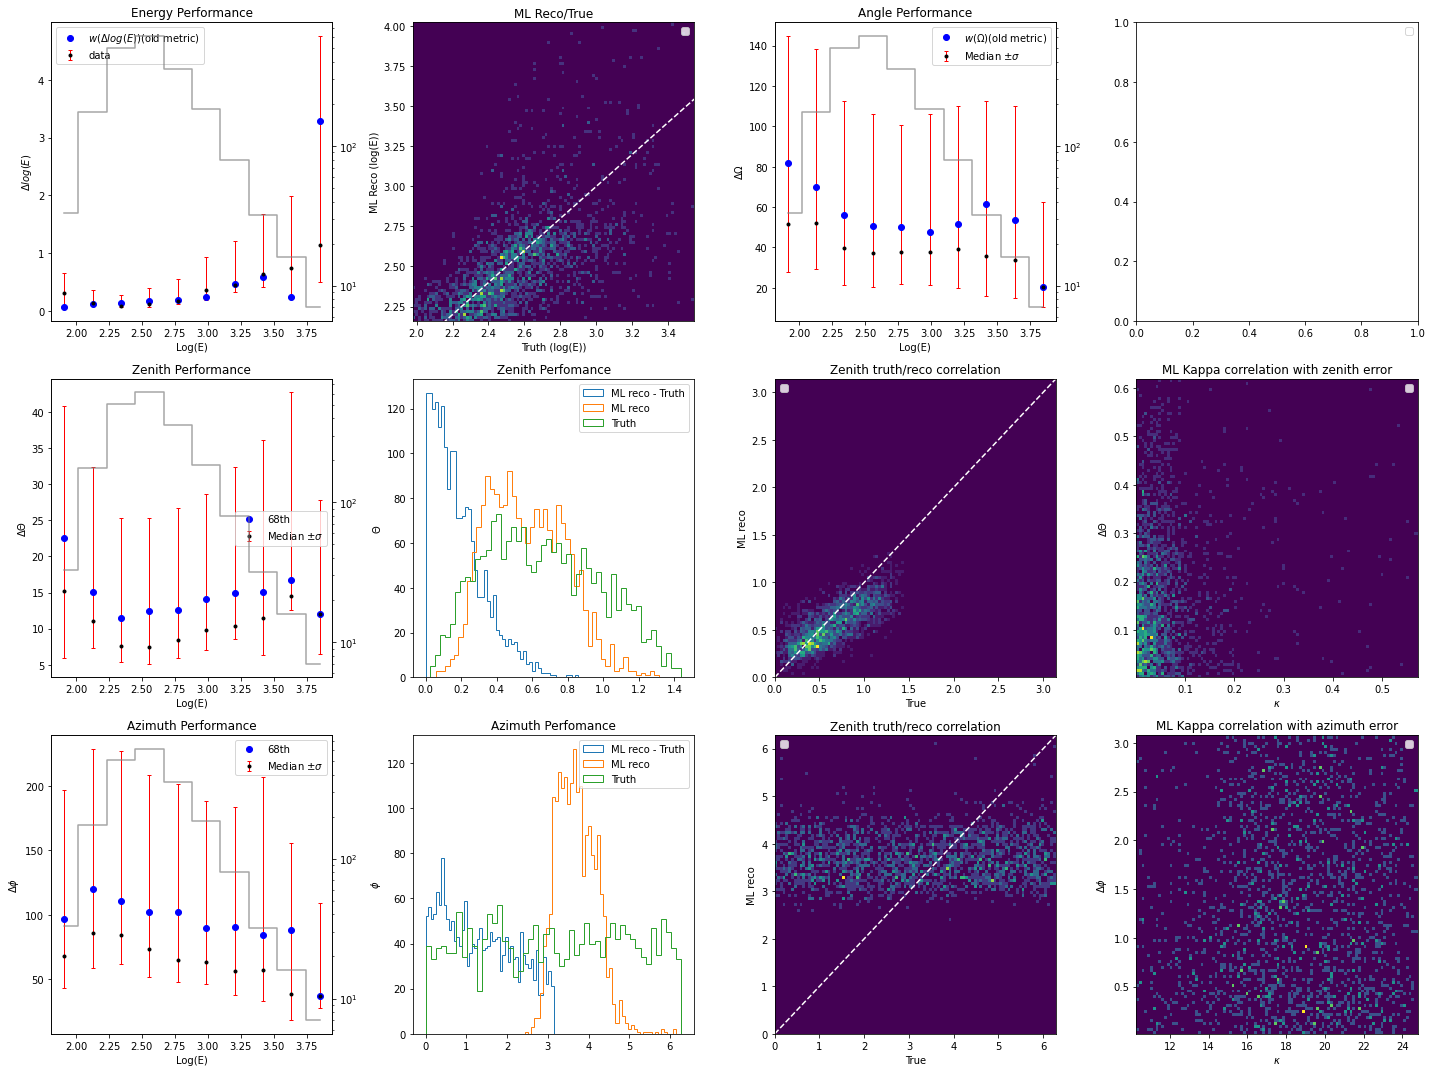

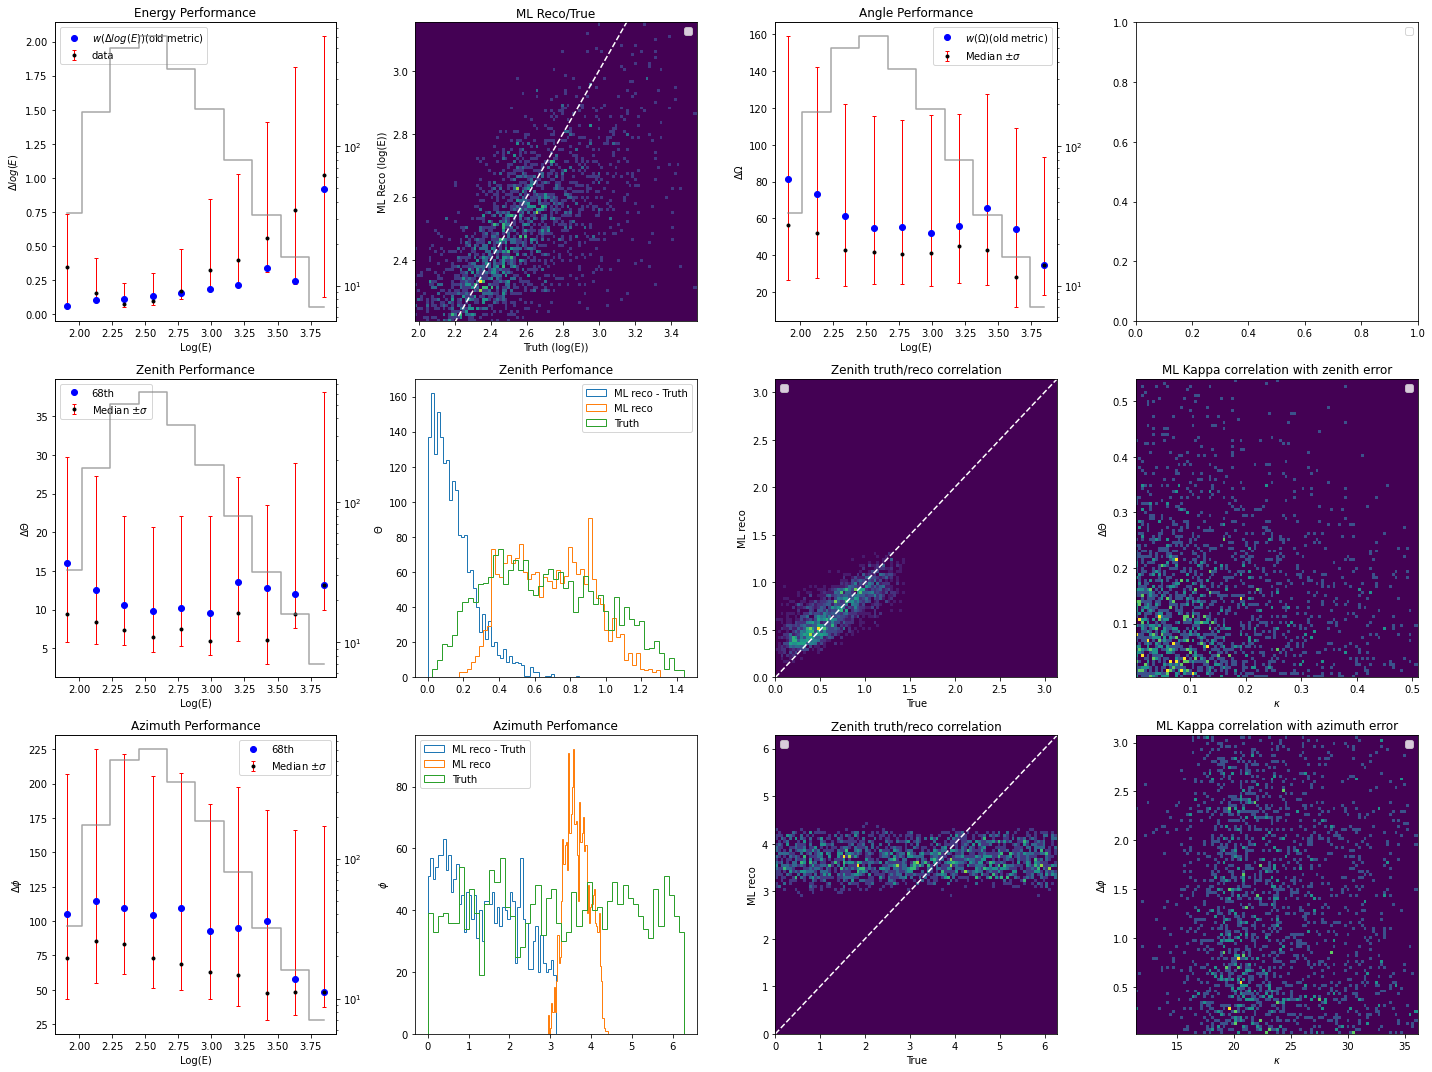

In [66]:
all, means=train_model(construct_dict)

In [78]:
summary=[]
for f in full:
    summary.append(tf.reduce_mean(f, axis=0)/tf.reduce_mean(f))
summary=np.array(summary)

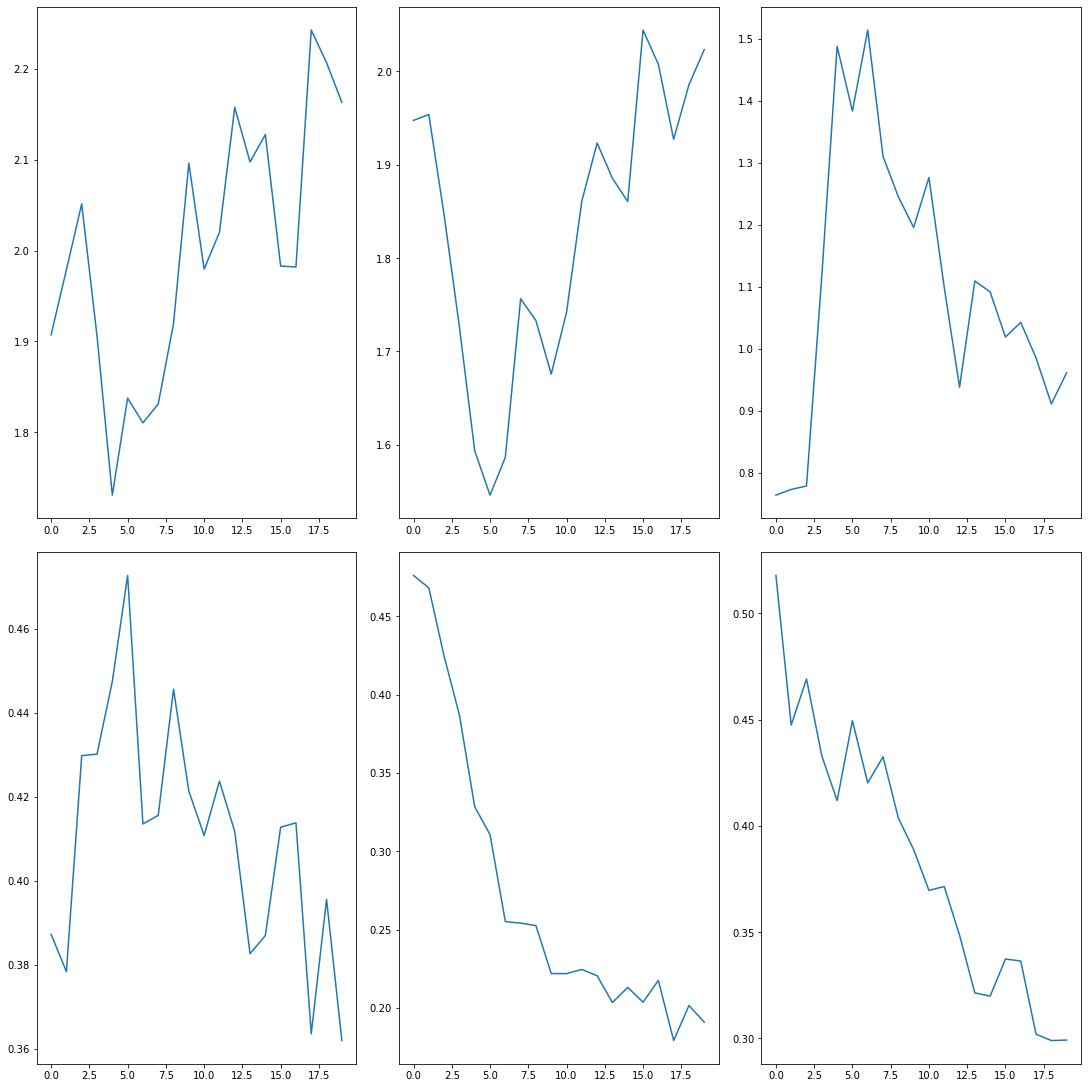

In [93]:
domx=summary[:,0]

ax = plt.figure(constrained_layout=True, figsize=(15,15)).subplot_mosaic(
    [['dom_x', 'dom_y', 'dom_z'],
    ['time', 'charge', 'SRT']])

ax['dom_x'].plot(summary[:,0],'')
ax['dom_y'].plot(summary[:,1])
ax['dom_z'].plot(summary[:,2])
ax['time'].plot(summary[:,3])
ax['charge'].plot(summary[:,4])
ax['SRT'].plot(summary[:,5])

AttributeError: 'dict' object has no attribute 'show'